# Overview

This notebook shows how to run a Langeving simulation and analyse the results using Mean Force Integration.

The notebook will be structured as follows:

 - Mean Force Integration in 1D
 - Mean Force Integration in 2D
 - Patching simulations in 2D
 
Some functions are taken from the Functions.ipynb file. Please refere to previous notebooks for more information.

In [2]:
#Import modules like numpy and matplotlib as well as functions defined in Functions.ipynb
%run Functions.ipynb

In [3]:
#make sure to run this cell in the right directory!!
path = os.getcwd()
print("The path to this notebook is:", path)

The path to this notebook is: /Users/matteo/Projects/MFI/Bjola_upgrade_report_files


# Define analytical free energy surface

The analytical free energy surface will be defined as $y(x) = 7*x^4-23*x^2$

It will be used to run Langevin dynamics simulations.

In [4]:
#Define the grid on which the mean force and the FES is calculated.
nbins = 401   
min_x = -2           
max_x = 2
grid_space = (max_x - min_x) / (nbins-1)
x = np.linspace(min_x,max_x,nbins)

#Define the analytical surface
y = 7*x**4 - 23*x**2
y = y - min(y)          #Set minima to 0

# Mean Force Integration

Mean Force Integration (MFI) is a method that analyses the trajectory and biases of a Metadynaimcs simulation. Using MFI, one can calculate the mean force, which can then be integrated to obtain the FES. 

More about the theory can be read in the origianl paper: Veselina Marinova and Matteo Salvalaglio, Time-independent free energies from metadynamics via mean force integration. Journal of Chemical Physics, 151, 10 2019.

In the next cells, it is shown how MFI can be implemented.

Frist the input files are written and a simulation is started.

In [5]:
os.chdir(path)
try: os.mkdir("MFI")
except: print("folder \"MFI\" already exists")
os.chdir("MFI")

#Runnig the simulation works the same way as for metadynamcis and WT-metadynamics, but
#one doesnt need to do the reweighting or calculate the histogram, just save the
#trajectory and the HILLS. Idealy, the ration of trajectory points to HILLS should be 10.

def run_langevin1D(length, sigma=0.1, height=0.1, biasfactor=10):
    with open("plumed.dat","w") as f:
        print("""p: DISTANCE ATOMS=1,2 COMPONENTS
ff: MATHEVAL ARG=p.x PERIODIC=NO FUNC=(7*x^4-23*x^2)
bb: BIASVALUE ARG=ff
METAD ARG=p.x PACE=100 SIGMA={} HEIGHT={} GRID_MIN=-3 GRID_MAX=3 GRID_BIN=200 BIASFACTOR={} TEMP=120
PRINT FILE=position ARG=p.x STRIDE=10""".format(sigma,height, biasfactor),file=f)

    with open("input","w") as f:
        print("""temperature 1
tstep 0.005
friction 1
dimension 1
nstep {}
ipos -1.0
periodic false""".format(length),file=f)
    
    #Start WT-Metadynamic simulation
    !plumed pesmd < input >/dev/null
    
run_langevin1D(1000)

folder "MFI" already exists


Next, the data is analysed. The key equation here is: 

$\frac{dF_t(x)}{dx} = - \frac{d \beta^{-1} ln(p_t^b(x))}{dx} - \frac{dV_t(x)}{dx}$ 

where $F$ is the Free Energy and $\frac{dF_t(x)}{dx}$ the mean force, $p_t^b(x)$ is the probability density, $V$ is the metadynamics bias, $t$ is the time and $x$ the collective variable.

Since the metadynamics bias evolves with the progression of the simulation, the term $\frac{dV_t(x)}{dx}$ is always changing. For this raeson, the term $\frac{dF_t(x)}{dx}$ is calculated for "windows" where the the metadymamics bias $V$ stays constant.

The $\frac{dF_t(x)}{dx}$ of each individual window are then summed up using a weighted sum approach, where the wight is the probability density of that time window. The weighted sum can be expressed as follows:

$\Big\langle \frac{dF_t(x)}{dx} \Big\rangle_t = \frac{\sum_t p_t^b(x) \frac{dF_t(x)}{dx}}{\sum_t p_t^b(x)}$

where $\Big\langle \frac{dF_t(x)}{dx} \Big\rangle_t$ is the average mean force, which is integrated to obtain the free energy.

More about the theory can be read in the origianl paper: Veselina Marinova and Matteo Salvalaglio, Time-independent free energies from metadynamics via mean force integration. Journal of Chemical Physics, 151, 10 2019.

In [6]:
#Load the HILLS data
def load_HILLS_1D(hills_name = "HILLS"):
    for file in glob.glob(hills_name):
        hills = np.loadtxt(file)
        hills = hills[:-1]
        hills0 = hills[0]
        hills0[3] = 0
        hills = np.concatenate(([hills0],hills))
    return hills

#Load the trajectory (position) data
def load_position_1D(position_name = "position"):
    for file1 in glob.glob(position_name):
        colvar = np.loadtxt(file1)
    return colvar[:-1, 1]

### Algorithm to run 1D MFI
def MFI_1D_simple():
    #initialise force terms
    Fbias = np.zeros(len(x));
    Ftot_num = np.zeros(len(x));
    Ftot_den = np.zeros(len(x));

    for i in range(total_number_of_hills):
        # Build metadynamics potential
        s = HILLS[i, 1]  # center position of gausian
        sigma_meta2 = HILLS[i, 2] ** 2  # width of gausian
        gamma = HILLS[i, 4]  #scaling factor of gausian
        height_meta = HILLS[i, 3] * ((gamma - 1) / (gamma))  # Height of Gausian
        kernelmeta = np.exp(-0.5 * (((x - s) ** 2) / (sigma_meta2)))
        Fbias = Fbias + height_meta * kernelmeta * ((x - s) / (sigma_meta2)) #Bias force due to Metadynamics potentials

        # Estimate the biased proabability density
        pb_t = np.zeros(len(x))
        Fpbt = np.zeros(len(x))
        data = position[i * stride: (i + 1) * stride] #positons of window of constant bias force.
        for j in range(stride):
            kernel = const * np.exp(- (x - data[j])**2 / (2*bw2) ) #probability density of 1 datapoint
            pb_t = pb_t + kernel #probability density of window 
            Fpbt = Fpbt + kT * kernel * (x - data[j]) / bw2

        # Estimate of the Mean Force
        Ftot_den = Ftot_den + pb_t   #total probability density
        dfds = np.divide(Fpbt, pb_t, out=np.zeros_like(Fpbt), where=pb_t != 0) + Fbias
        Ftot_num = Ftot_num + pb_t * dfds
        Ftot = np.divide(Ftot_num, Ftot_den, out=np.zeros_like(Ftot_num), where=Ftot_den != 0) #total force

        if (i+1) % (total_number_of_hills/10) == 0:
            print(str(i+1) + " / " + str(total_number_of_hills))
            
    return [Ftot_den, Ftot]

        
# Integrate Ftot, obtain FES 
def intg_1D(F):
    fes = []
    for j in range(len(x)): fes.append(integrate.simps(F[:j + 1], x[:j + 1]))
    fes = fes - min(fes)
    return fes

# Calculate average deviation of 1D FES
def error_1D(FES):
    AD = abs(FES - y)
    AAD = sum(AD) / len(AD)
    print("The AAD of the FES is: " + str(AAD))
    return (AD, AAD)

#define indexing
def index(position, min_grid=min_x, _grid_space=grid_space):
    return int((position-min_grid)//_grid_space) + 1


# Calculate average deviation of 1D FES in central region [range_min, range_max]. e.g. [-1.75, 1.75]
def error_1D_centre(FES, range_min, range_max):
    AD = abs(FES[index(-1.75):index(1.75)+1] - y[index(-1.75):index(1.75)+1])
    AAD = sum(AD) / len(AD)
    print("The AAD of the FES from x=" + str(range_min) +" to x=" + str(range_max) + " is: " + str(AAD))
    return (AD, AAD)

In [7]:
HILLS = load_HILLS_1D()
position = load_position_1D()
                      
#Define constants
bw = 0.02         # bw: bandwidth for the KDE of the biased probability density
bw2 = bw**2
kT = 1          # kT:       value of kT
stride = int(len(position) / len(HILLS[:,1]))     
const = (1 / (bw*np.sqrt(2*np.pi)*stride))
total_number_of_hills=len(HILLS[:,1])
print("total number of hills:", total_number_of_hills)

#Analyze trajectory to obtain mean force Ftot
[Ftot_den, Ftot] = MFI_1D_simple()

# Integrate Ftot, obtain FES 
FES = intg_1D(Ftot)

# calculate error  
(AD, AAD) = error_1D(FES)
(AD_centre, AAD_centre) = error_1D_centre(FES, -1.75, 1.75)


total number of hills: 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
The AAD of the FES is: 444.21631493575563
The AAD of the FES from x=-1.75 to x=1.75 is: 449.67673566211494


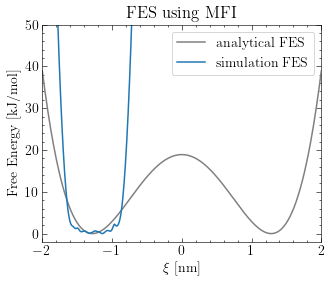

In [8]:
#plot analytical fes
plt.plot(x, y, color="grey", label="analytical FES")

#plot fes
plt.plot(x, FES, label="simulation FES")
plt.xlabel("$\\xi$ [nm]")
plt.ylabel("Free Energy [kJ/mol]")
plt.title("FES using MFI")
plt.xlim(-2,2)
plt.ylim(-2,50)
plt.legend()
plt.show()

72


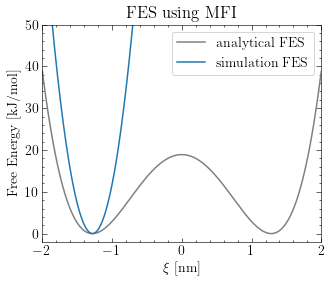

In [9]:
#plot analytical fes
plt.plot(x, y, color="grey", label="analytical FES")

#plot fes
print(index(-1.28))

plt.plot(x, 150*(x+1.28)**2, label="simulation FES")


plt.xlabel("$\\xi$ [nm]")
plt.ylabel("Free Energy [kJ/mol]")
plt.title("FES using MFI")
plt.xlim(-2,2)
plt.ylim(-2,50)
plt.legend()
plt.show()

# Mean Force Integration in 2 Dimensions

The Mean Force Integration in 2 dimensions works in the same way as in one dimension. The reason for using two dimensional MFI, is that it allows to use 2 collective variables instead of one, which might be necessary for some systems.

First, the theoretical function is defined, which is analogous to the 1 dimensional used above.

Next, the input files need to be written, which require small changes, and the simulation can be started. 

As the position and HILLS file are available, the MFI algoritm is used to find the mean force. Instead of using a 1 dimensional gausian distributions for the probability density and the metadynamics bias (or other biases), a 2 dimensional gausian distribution is used.

The derivative of a 2 dimensional free energy is expressed as 2 independent gradients, where each gradients corresponds to the derivative w.r.t. one dimension. The integration of the gradient isn't very straight forward and more complicated when the gradients are noisy. 


In [10]:
os.chdir(path)
try: os.mkdir("MFI_2D")
except: print("folder \"MFI_2D\" already exists")
os.chdir("MFI_2D")

folder "MFI_2D" already exists


/var/folders/4v/jxb311rn5nq2q59y91zzgxd40000gp/T/ipykernel_84917/7339150.py:13: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fes3d.gca(projection='3d')


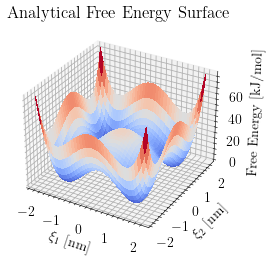

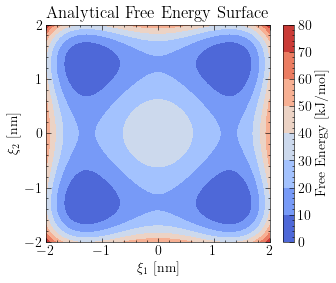

In [11]:
#Define Grid and theoretical function
nbins = 201
min_grid = -2
max_grid = 2
grid = np.linspace(min_grid, max_grid, nbins)
grid_space = (max_grid - min_grid) / (nbins - 1)
X, Y = np.meshgrid(grid, grid)
Z = 7*X**4 - 23*X**2 + 7*Y**4 - 23*Y**2
Z = Z - np.min(Z)

#Plot theoretical Function
fes3d = plt.figure(81)
ax = fes3d.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap="coolwarm", linewidth=0, antialiased=False)
# fes3d_woco.colorbar(surf, shrink=0.5, aspect=5)
plt.title("Analytical Free Energy Surface")
ax.set_xlabel(r"$\xi_1$ [nm]")
ax.set_ylabel(r"$\xi_2$ [nm]")
ax.set_zlabel('Free Energy [kJ/mol]');plt.savefig('Analtical3D_7x^4-23x^2.png', dpi=600, bbox_inches='tight')
plt.show()

#Plot theoretical Function
plt.figure(82)
plt.contourf(X, Y, Z, cmap='coolwarm')
plt.colorbar(label="Free Energy [kJ/mol]")
plt.xlabel(r"$\xi_1$ [nm]")
plt.ylabel(r"$\xi_2$ [nm]")
plt.title("Analytical Free Energy Surface")
plt.show()

In [12]:
os.chdir(path + "/MFI_2D")

def run_langevin2D(length, sigma=0.1, height=0.1, biasfactor=10, ipos=np.array([-1,-1])):
    with open("plumed.dat","w") as f:
        print("""p: DISTANCE ATOMS=1,2 COMPONENTS
ff: MATHEVAL ARG=p.x,p.y PERIODIC=NO FUNC=(7*x^4-23*x^2+7*y^4-23*y^2)
bb: BIASVALUE ARG=ff
METAD ARG=p.x,p.y PACE=100 SIGMA={},{} HEIGHT={} GRID_MIN=-3,-3 GRID_MAX=3,3 GRID_BIN=300,300 BIASFACTOR={} TEMP=120 CALC_RCT
#Uncomment following lines to obtain the FES using plumed functions:
#bias: REWEIGHT_METAD TEMP=120
#hh: HISTOGRAM ARG=p.x,p.y GRID_MIN=-3,-3 GRID_MAX=3,3 GRID_BIN=300,300 BANDWIDTH=0.01,0.01 LOGWEIGHTS=bias
#fes: CONVERT_TO_FES GRID=hh TEMP=120
#DUMPGRID GRID=fes FILE=fes.dat STRIDE={}
PRINT FILE=position ARG=p.x,p.y STRIDE=10""".format(sigma, sigma, height, biasfactor, length),file=f)

    with open("input","w") as f:
        print("""temperature 1
tstep 0.005
friction 1
dimension 2
nstep {}
ipos {},{}
periodic false""".format(length,ipos[0],ipos[1]),file=f)

    !plumed pesmd < input  >/dev/null
    
run_langevin2D(5000000,height=0.5)

In [ ]:
def load_HILLS_2D(hills_name = "HILLS"):
    for file in glob.glob(hills_name):
        hills = np.loadtxt(file)
        hills = np.concatenate(([hills[0]], hills[:-1]))
        hills[0][5] = 0
    return hills

def load_position_2D(position_name = "position"):
    for file1 in glob.glob(position_name):
        colvar = np.loadtxt(file1)
        position_x = colvar[:-1, 1]
        position_y = colvar[:-1, 2]
    return [position_x, position_y]
        

def MFI_2D_simple():    
    count = 0
    # Initialize force terms
    Fbias_x = np.zeros((nbins, nbins))
    Fbias_y = np.zeros((nbins, nbins))
    Ftot_num_x = np.zeros((nbins, nbins))
    Ftot_num_y = np.zeros((nbins, nbins))
    Ftot_den = np.zeros((nbins, nbins))

    for i in range(total_number_of_hills):
        # Build metadynamics potential
        s_x = HILLS[i, 1]  # center x-position of gausian
        s_y = HILLS[i, 2]  # center y-position of gausian
        sigma_meta2_x = HILLS[i, 3] ** 2  # width of gausian
        sigma_meta2_y = HILLS[i, 4] ** 2  # width of gausian
        gamma = HILLS[i, 6]
        height_meta = HILLS[i, 5] * ((gamma - 1) / (gamma))  # Height of Gausian

        kernelmeta = np.exp(-0.5 * (((X - s_x) ** 2) / sigma_meta2_x + ((Y - s_y) ** 2) / sigma_meta2_y))  # potential erorr in calc. of s-s_t
        Fbias_x = Fbias_x + height_meta * kernelmeta * ((X - s_x) / sigma_meta2_x);  ##potential erorr in calc. of s-s_t
        Fbias_y = Fbias_y + height_meta * kernelmeta * ((Y - s_y) / sigma_meta2_y);  ##potential erorr in calc. of s-s_t

        # Biased probability density component of the force
        # Etimate the biased proabability density p_t ^ b(s)
        pb_t = np.zeros((nbins, nbins))
        Fpbt_x = np.zeros((nbins, nbins))
        Fpbt_y = np.zeros((nbins, nbins))

        data_x = position_x[i * stride: (i + 1) * stride]
        data_y = position_y[i * stride: (i + 1) * stride]
        for j in range(stride):
            kernel = const * np.exp(- ((X - data_x[j]) ** 2 + (Y - data_y[j]) ** 2) / (2 * bw2) )
            pb_t = pb_t + kernel;
            Fpbt_x = Fpbt_x + kernel * (X - data_x[j]) / bw2
            Fpbt_y = Fpbt_y + kernel * (Y - data_y[j]) / bw2

        # Calculate Mean Force
        Ftot_den = Ftot_den + pb_t;
        # Calculate x-component of Force
        dfds_x = np.divide(Fpbt_x * kT, pb_t, out=np.zeros_like(Fpbt_x), where=pb_t != 0) + Fbias_x
        Ftot_num_x = Ftot_num_x + pb_t * dfds_x
        Ftot_x = np.divide(Ftot_num_x, Ftot_den, out=np.zeros_like(Fpbt_x), where=Ftot_den != 0)
        # Calculate y-component of Force
        dfds_y = np.divide(Fpbt_y * kT, pb_t, out=np.zeros_like(Fpbt_y), where=pb_t != 0) + Fbias_y
        Ftot_num_y = Ftot_num_y + pb_t * dfds_y
        Ftot_y = np.divide(Ftot_num_y, Ftot_den, out=np.zeros_like(Fpbt_y), where=Ftot_den != 0)

        if (i+1) % (total_number_of_hills/10) == 0: 
            print(str(i+1) + " / " + str(total_number_of_hills))
            
    return [Ftot_den, Ftot_x, Ftot_y]

### Integrtion using Fast Fourier Transform (FFT integration) in 2D            
def FFT_intg_2D(FX, FY):
    #Calculate frequency
    freq_1d = np.fft.fftfreq(nbins, grid_space)
    freq_x, freq_y = np.meshgrid(freq_1d, freq_1d)
    freq_hypot = np.hypot(freq_x, freq_y)
    freq_sq = np.where(freq_hypot != 0, freq_hypot ** 2, 1E-10)
    #FFTransform and integration
    fourier_x = (np.fft.fft2(FX) * freq_x) / (2 * np.pi * 1j * freq_sq)
    fourier_y = (np.fft.fft2(FY) * freq_y) / (2 * np.pi * 1j * freq_sq)
    #Reverse FFT
    fes_x = np.real(np.fft.ifft2(fourier_x))
    fes_y = np.real(np.fft.ifft2(fourier_y))
    #Construct whole FES
    fes = fes_x + fes_y
    fes = fes - np.min(fes)
    return fes

# Calculate average deviation of 2D FES
def error_2D(FES):
    AD = abs(FES - Z)
    AAD = sum(sum(AD))/(nbins**2)
    print("The AAD of the FES is: " + str(AAD))
    return (AD, AAD)


In [109]:
HILLS = load_HILLS_2D()
[position_x, position_y] = load_position_2D()


#Define Constants
bw = 0.1  # bw: bandwidth for the KDE of the biased probability density
bw2 = bw**2        
kT = 1          # kT:       value of kT
stride = int(len(position_x) / len(HILLS[:,1]))     
const = (1 / (bw*np.sqrt(2*np.pi)*stride))
total_number_of_hills=len(HILLS[:,1])
print("total number of hills:", total_number_of_hills)

[Ftot_den, Ftot_x, Ftot_y] = MFI_2D_simple()

FES = FFT_intg_2D(Ftot_x, Ftot_y)

(AD, AAD) = error_2D(FES)


total number of hills: 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
1000 / 1000
The AAD of the FES is: 47.34984943410729


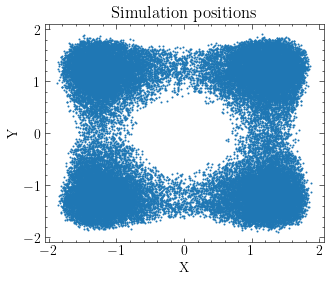

In [93]:
plt.scatter(position_x,position_y,s=1)
plt.title("Simulation positions")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

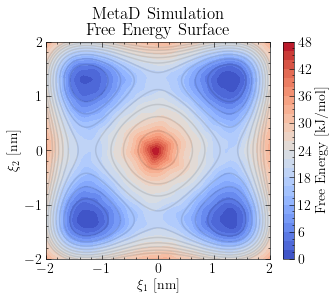

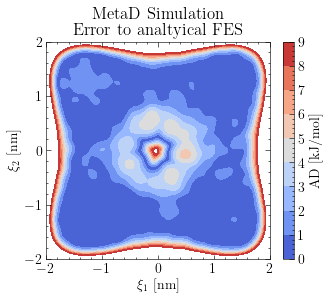

In [94]:
plt.figure(1)
plt.contourf(X, Y, FES, levels=range(0,50,2), cmap='coolwarm');
plt.colorbar(label="Free Energy [kJ/mol]")
plt.contour(X, Y, Z, levels=range(0,50,5), colors="black", alpha=0.1);
plt.xlabel(r"$\xi_1$ [nm]")
plt.ylabel(r"$\xi_2$ [nm]")
plt.title("MetaD Simulation \nFree Energy Surface")

plt.figure(2)
plt.contourf(X, Y, AD, cmap='coolwarm', levels=range(0,10,1))#
plt.colorbar(label="AD [kJ/mol]")
plt.xlabel(r"$\xi_1$ [nm]")
plt.ylabel(r"$\xi_2$ [nm]")
plt.title("MetaD Simulation \nError to analtyical FES")
plt.show()

In [95]:
Ftot_den0 = np.array(Ftot_den)
Ftot_x0 = np.array(Ftot_x)
Ftot_y0 = np.array(Ftot_y)

# Patching simulations

This part requires the terms Ftot_den0, Ftot_x0 and Ftot_y0 to be defined as the force terms obtained from the previous 2D simulation.

Due to the the equations used in the MFI theory, multiple force terms from independent simulations can be patched together and treated as force terms from the same simulation. Considering following equation:

$\Big\langle \frac{dF_t(x)}{dx} \Big\rangle_t = \frac{\sum_t p_t^b(x) \frac{dF_t(x)}{dx}}{\sum_t p_t^b(x)}$

Instead of using the mean force and probability density of the individual windows, one can use the average mean force and the respective probability density of independent simulations. 

To present this concept, the previous simulation data (Ftot_den0, Ftot_x0 and Ftot_y0) will be patched with a new simulation. Given that the previous simulation never reached regions of higher energy, the new simulation will have higher hills for the metadynamics bias ( i.e. a stronger drive towards regions of high energy)


In [82]:
os.chdir(path + "/MFI_2D")

In [114]:
run_langevin2D(50000, height=5, ipos=np.array([-1,1]))

Now that there are two independent simulations they can patched together. 

For this purpose, the force terms are collected in a list called "master"

In [115]:
def patch_2D(master_array):

    FX = np.zeros((nbins, nbins))
    FY = np.zeros((nbins, nbins))
    FP = np.zeros((nbins, nbins))

    for i in range(len(master)):
        FX += master_array[i][0] * master_array[i][1]
        FY += master_array[i][0] * master_array[i][2]
        FP += master_array[i][0]

    FX = np.divide(FX, FP, out=np.zeros_like(FX), where=FP != 0)
    FY = np.divide(FY, FP, out=np.zeros_like(FY), where=FP != 0)
    
    return [FP, FX, FY]

master = []
master.append([Ftot_den0, Ftot_x0, Ftot_y0])
master.append([Ftot_den, Ftot_x, Ftot_y])

[Ftot_den_patch, Ftot_x_patch, Ftot_y_patch] = patch_2D(master)



In [116]:
FES = FFT_intg_2D(Ftot_x_patch, Ftot_y_patch)

(AD, AAD) = error_2D(FES)

The AAD of the FES is: 3.9896922743740504


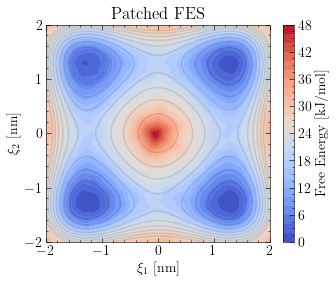

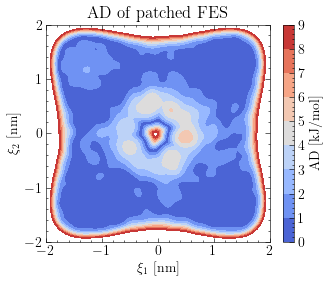

In [117]:
plt.figure(1)
plt.contourf(X, Y, FES, levels=range(0,50,2), cmap='coolwarm');
plt.colorbar(label="Free Energy [kJ/mol]")
plt.contour(X, Y, Z, levels=range(0,50,5), colors="black", alpha=0.1);
plt.xlabel(r"$\xi_1$ [nm]")
plt.ylabel(r"$\xi_2$ [nm]")
plt.title("Patched  FES")


plt.figure(2)
plt.contourf(X, Y, AD, cmap='coolwarm', levels=range(0,10,1))#
plt.colorbar(label="AD [kJ/mol]")
plt.xlabel(r"$\xi_1$ [nm]")
plt.ylabel(r"$\xi_2$ [nm]")
plt.title("AD of patched FES")
plt.show()

Although the patch FES is better than the FES from the first simulation, it is slightly worse than the FES from the second simulation.

This is not necessarily a typical feature of the patching technique. For very simple systems like the one above, it is sometimes enough to run one simulation with a good choice of parameters. However, the patching technique can be very useful for more complex systems where running only one simulation might be inadequate. Additionally, more complex simulation setups are possible, such as combining a metadynamics simulation with an umbrella sampling simulation, which will be discussed in the next notebook.